In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA


In [2]:
new_df = pd.read_csv('Archivos/NewDataAll.csv', low_memory=False)
causas_vih = pd.read_csv('Archivos/causas_vih.csv', low_memory=False)
enfermedades = pd.read_excel('Archivos/CIE10.xlsx')



In [31]:
enfermedades2 = enfermedades.copy()
enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] = enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] + "X"
enfermedades2

new_df2 = pd.merge(new_df, enfermedades2, left_on='caudef', right_on='CAUSA', how='left')

new_df2 = new_df2.dropna()
causas_infecciones = new_df2.loc[new_df2["DESCRIPCION"].str.contains("Infecciones|infecciones|infeccion|Infección|Infeccion|infección")]

causas_vih_index = new_df2.loc[new_df2["DESCRIPCION"].str.contains("VIH|vih|SIDA")].index
causas_vih_index = new_df2.loc[new_df2["DESCRIPCION"].str.contains("VIH|vih|SIDA")]




In [4]:
new_df2['VIH'] = 0
new_df2.loc[causas_vih_index, 'VIH'] = 1


Datos sobre que tanto subieron o bajaron las muertes por vih

In [5]:
tf_cvih = pd.crosstab(causas_vih['añoocu'], columns='count')
v09 = tf_cvih['count'][2009]
v20 = tf_cvih['count'][2020]

d1 =(abs(v09-v20)/v09)*100
d1

63.53503184713376

Datos sobre que tanto subieron las muertes desde 2009 hasta 2020

In [6]:
tf_ndf = pd.crosstab(new_df['añoocu'], columns='count')
d09 = tf_ndf['count'][2009]
d20 = tf_ndf['count'][2020]

dif =(abs(d09-d20)/d09)*100
dif

33.879537562581056

Cuanto ha bajado el porcentaje de muertes que representa el vih desde el 2009 hasta el 2020

In [7]:
por_vih09 = (v09/d09)*100 #0.876 porciento de las muertes en 2009 fueron causadas por vih
por_vih20 = (v20/d20)*100 #0.239 porciento de las muertes en 2020 fueron causadas por vih

dif_porvih = abs(por_vih09-por_vih20)*100/por_vih09
dif_porvih

72.76285172719471

# Logistic Regression

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

columns = ['depocu', 'sexo',
       'edadif', 'perdif', 'ecidif', 'dnadif',
       'nacdif', 'dredif', 'asist', 'ocur',
       'cerdef']

X = new_df2[columns]
y = new_df2['VIH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)


c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [22]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

true_negative = confusion[0, 0]
false_positive = confusion[0, 1]
false_negative = confusion[1, 0]
true_positive = confusion[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


print(classification_report(y_test, y_pred))



Accuracy: 0.7377606123625942
Sensitivity: 0.7768037761294673
Specificity: 0.7375571811033581
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    284622
           1       0.02      0.78      0.03      1483

    accuracy                           0.74    286105
   macro avg       0.51      0.76      0.44    286105
weighted avg       0.99      0.74      0.84    286105



# SVM

In [23]:

# Get the indices of rows where caudef is 1 (HIV deaths)

new_df3 = new_df2.copy()
hiv_indices = new_df3[new_df3['VIH'] == 1].index

# Sample a portion of non-HIV death cases
non_hiv_sample = new_df3[new_df3['VIH'] == 0].sample(n=100000 - len(hiv_indices), random_state=42)

# Concatenate the HIV death cases and non-HIV death cases
sample = pd.concat([new_df3.loc[hiv_indices], non_hiv_sample])

# Shuffle the sample
sample = sample.sample(frac=1, random_state=42)

X = sample[columns]
y = sample['VIH']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
len(X_test)
len(X_train)

35000

In [24]:
from sklearn.svm import SVC



svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', class_weight='balanced')
svm_model.fit(X_train, y_train)




print('done modelfit')
# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)
print('done ypred')
# Calcular la precisión (accuracy), sensibilidad (sensitivity) y especificidad (specificity)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

true_negative = confusion[0, 0]
false_positive = confusion[0, 1]
false_negative = confusion[1, 0]
true_positive = confusion[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


print(classification_report(y_test, y_pred))

done modelfit
done ypred
Accuracy: 0.8598333333333333
Sensitivity: 0.6635135135135135
Specificity: 0.8700210378681626
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28520
           1       0.21      0.66      0.32      1480

    accuracy                           0.86     30000
   macro avg       0.59      0.77      0.62     30000
weighted avg       0.94      0.86      0.89     30000



# Arima

<AxesSubplot:xlabel='añoocu'>

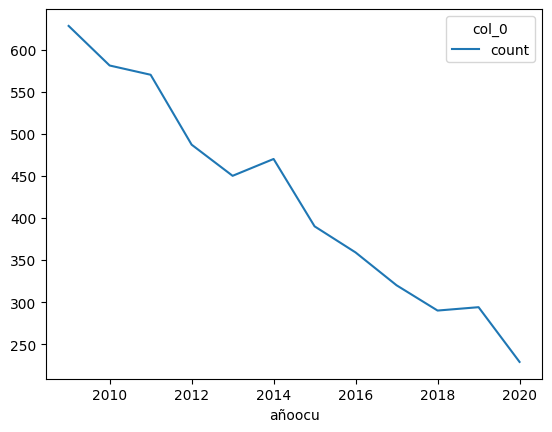

In [76]:
causas_vih2 = causas_vih.copy()

causas_vih2['new_mesocu'] = causas_vih2['mesocu']+(causas_vih2['añoocu']-2009)*12


vih_deaths = causas_vih2['new_mesocu']

vih_deaths = causas_vih2['añoocu']

time_series = pd.crosstab(vih_deaths, columns='count')

time_series.plot()


In [83]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
train_size = int(len(time_series) * 0.8)  # 80% for training, 20% for testing
train_data = time_series[:train_size]
test_data = time_series[train_size:]
# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 1))  # You can adjust the order parameters based on the data
model_fit = model.fit()

# Forecast future values using the ARIMA model
forecast = model_fit.forecast(steps=len(test_data))
forecast
# Compare the forecasted values with the actual values in the test set
predictions = np.round(forecast).astype(int)
actual_values = test_data.values
accuracy = accuracy_score(actual_values, predictions)
confusion = confusion_matrix(actual_values, predictions)
true_negative = confusion[0, 0]
false_positive = confusion[0, 1]
false_negative = confusion[1, 0]
true_positive = confusion[1, 1]


## Evaluate the accuracy of the predictions (you can use different metrics depending on your specific requirements)
accuracy = classification_report(actual_values, predictions)
## You can now use the trained model to forecast HIV deaths for future years
future_forecast = np.round(model_fit.forecast(steps=1)).astype(int)  # Forecast for the next year
#

## Print the forecasted value for the next year
print(f"Forecast for the Next Year: {future_forecast.values}")

c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

Forecast for the Next Year: [285]
